In [6]:
#%pip install keras
#%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
from keras import Sequential, Model
import numpy as np
from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop

import sys
#sys.path.append('../..')

import ep.etools as apt


ModuleNotFoundError: No module named 'sklearn'

In [3]:
# import des données financières de Yahoo
import yfinance as yf
etf = ['BZ=F','EURUSD=X','TTF=F']
data = yf.Ticker(etf[0])

In [4]:
dataH = data.history(start='2007-01-01',period='1d')
# dataH

In [5]:
it = yf.download(tickers=etf, period='1d',start='2009-01-01')
it.describe()

[*********************100%***********************]  3 of 3 completed


Adj Close                                  Close               \
              BZ=F     EURUSD=X        TTF=F         BZ=F     EURUSD=X   
count  3699.000000  3887.000000  1539.000000  3699.000000  3887.000000   
mean     77.096337     1.211679    44.061738    77.096337     1.211679   
std      24.585977     0.122164    48.789248    24.585977     0.122164   
min      19.330000     0.959619     3.510000    19.330000     0.959619   
25%      56.969999     1.111531    15.222500    56.969999     1.111531   
50%      74.660004     1.181181    22.475000    74.660004     1.181181   
75%     101.190002     1.318905    49.631500   101.190002     1.318905   
max     127.980003     1.512791   339.196014   127.980003     1.512791   

                           High                                    Low  \
             TTF=F         BZ=F     EURUSD=X        TTF=F         BZ=F   
count  1539.000000  3699.000000  3887.000000  1539.000000  3699.000000   
mean     44.061738    78.009792     1.216012    44.609285    76.113693   
std      48.789248    24.644671     0.122798    49.009219    24.478202   
min       3.510000    21.270000     0.967006     3.850000    16.000000   
25%      15.222500    57.840000     1.115287    15.400000    56.064999   
50%      22.475000    75.540001     1.183800    22.549999    73.779999   
75%      49.631500   102.680000     1.323711    50.789999   100.205002   
max     339.196014   137.000000     1.514532   339.196014   125.300003   

                                        Open                            \
          EURUSD=X        TTF=F         BZ=F     EURUSD=X        TTF=F   
count  3887.000000  1539.000000  3699.000000  3887.000000  1539.000000   
mean      1.207160    43.510728    77.085645     1.211702    44.036418   
std       0.121748    48.501643    24.565672     0.122236    48.721545   
min       0.760572     3.500000    19.559999     0.959619     3.700000   
25%       1.107769    15.125000    56.934999     1.111451    15.197500   
50%       1.177329    22.379999    74.599998     1.181154    22.500000   
75%       1.313603    48.244999   101.579998     1.318800    49.084999   
max       1.504099   339.196014   129.570007     1.512608   339.196014   

             Volume                        
               BZ=F EURUSD=X        TTF=F  
count   3699.000000   3887.0  1539.000000  
mean   18672.846986      0.0   291.969461  
std    16234.256952      0.0   538.581449  
min        0.000000      0.0     0.000000  
25%     1258.000000      0.0     0.000000  
50%    19315.000000      0.0    55.000000  
75%    30869.500000      0.0   370.000000  
max    87185.000000      0.0  5920.000000

In [6]:
# supprime colonnes inutiles
it.drop(['High','Low','Open','Volume','Adj Close'],axis=1,inplace=True)
print(it.columns.to_list())
# it.rename(columns='_'.join,inplace=True)
it.columns = it.columns.map('_'.join)
it.rename(columns={'Close_BZ=F':'brent','Close_EURUSD=X':'FX'},inplace=True)
it.describe()

[('Close', 'BZ=F'), ('Close', 'EURUSD=X'), ('Close', 'TTF=F')]


,brent,FX,Close_TTF=F
count,3699.000000,3887.000000,1539.000000
mean,77.096337,1.211679,44.061738
std,24.585977,0.122164,48.789248
min,19.330000,0.959619,3.510000
25%,56.969999,1.111531,15.222500
50%,74.660004,1.181181,22.475000
75%,101.190002,1.318905,49.631500
max,127.980003,1.512791,339.196014


In [7]:
it.dropna(axis=0,inplace=True)
it.describe()

,brent,FX,Close_TTF=F
count,1533.000000,1533.000000,1533.000000
mean,71.511044,1.128665,44.166768
std,18.756902,0.058955,48.855071
min,19.330000,0.959619,3.510000
25%,61.889999,1.090334,15.230000
50%,71.580002,1.128796,22.500000
75%,82.669998,1.175696,49.924000
max,127.980003,1.251001,339.196014


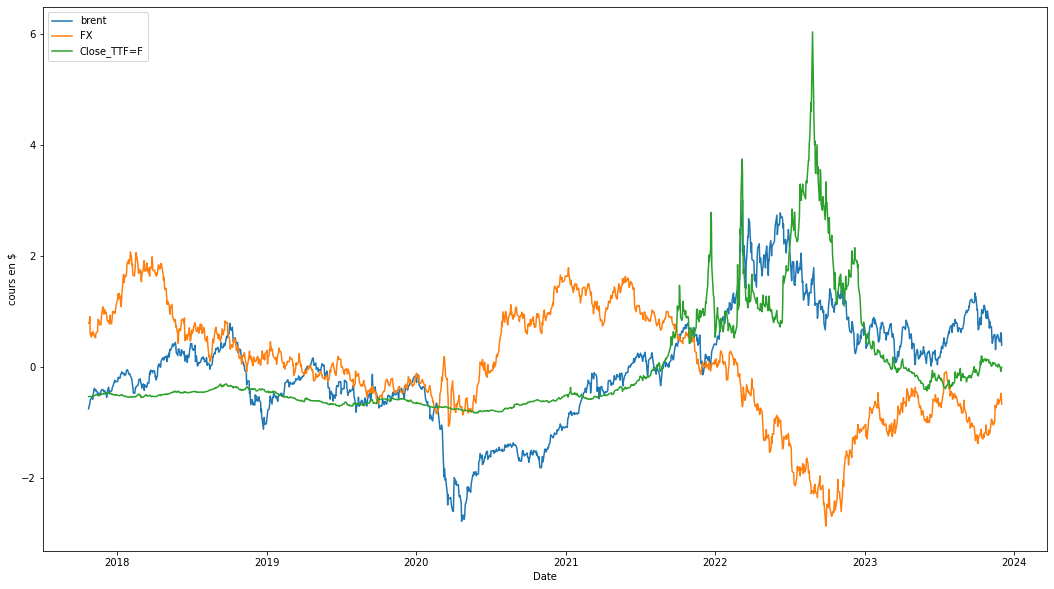

In [8]:
import matplotlib.pyplot as plt
it_plot = it.copy()
# normalisation
it_mean = it.mean(axis=0)
it_std = it.std(axis=0)
it_plot = (it_plot - it_mean) /it_std
# plot
plt.figure(figsize=(18,10))
plt.xlabel('Date')
plt.ylabel('cours en $')
plt.plot(it_plot,label=it_plot.columns.to_list())
plt.legend(loc='upper left')
plt.show()

In [9]:
# parametres
scale            = 1        # % du dataset (1=all)
train_prop       = .8       # ration du train vs test
sequence_len     = 8
batch_size       = 32
epochs           = 10
features         = ['brent','FX']
features_len     = len(features)

In [15]:
# Mise à l'échelle du dataFrame

df = it[:int(scale*len(it))].reset_index()
train_len=int(train_prop*len(df))

print(df)

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
apt.subtitle('Train dataset :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

apt.subtitle('Après normalisation :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

apt.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

           Date      brent        FX  Close_TTF=F
0    2017-10-23  57.369999  1.175364    18.090000
1    2017-10-24  58.330002  1.175917    17.959999
2    2017-10-25  58.439999  1.175903    18.110001
3    2017-10-26  59.299999  1.182075    18.070000
4    2017-10-27  60.439999  1.163724    18.150000
...         ...        ...       ...          ...
1528 2023-11-27  79.980003  1.094044    43.984001
1529 2023-11-28  81.680000  1.095842    42.773998
1530 2023-11-29  83.099998  1.100594    40.360001
1531 2023-11-30  82.830002  1.097370    42.091000
1532 2023-12-01  78.879997  1.089206    43.895000

[1533 rows x 4 columns]


<br>**Train dataset :**

,brent,FX
0,57.369999,1.175364
1,58.330002,1.175917
2,58.439999,1.175903
3,59.299999,1.182075
4,60.439999,1.163724
5,60.900002,1.160456
6,61.369999,1.165270
7,61.290001,1.165175
8,60.619999,1.162872
9,62.070000,1.166181


<br>**Après normalisation :**

,brent,FX
count,1226.00,1226.00
mean,0.00,0.00
std,1.00,1.00
min,-2.51,-2.96
25%,-0.45,-0.60
50%,-0.08,-0.07
75%,0.40,0.71
max,3.06,2.03


<br>**Shapes :**

Dataset       :  (1533, 4)
Train dataset :  (1226, 2)
Test  dataset :  (307, 2)


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# ---- Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

apt.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
apt.subtitle('What a batch looks like (x[0]) :')
apt.np_print(x[0] )
apt.subtitle('What a batch looks like (y[0]) :')
apt.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  39
batch x shape :  (32, 8, 2)
batch y shape :  (32, 2)


<br>**What a batch looks like (x[0]) :**

[[-0.563  0.587]
 [-0.514  0.597]
 [-0.508  0.597]
 [-0.464  0.715]
 [-0.406  0.364]
 [-0.382  0.301]
 [-0.358  0.393]
 [-0.362  0.392]]


<br>**What a batch looks like (y[0]) :**

[-0.397  0.347]


In [18]:
# tf.config.get_visible_devices()
# tf.config.PhysicalDevice('CPU:0','CPU')

In [19]:
print(tf.__version__)

2.9.2


In [20]:
run_dir = './run/'
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [21]:
# le model Keras
input_data = Input(shape=(sequence_len,features_len))
x = layers.GRU(100, dropout=0.2,return_sequences=True, recurrent_dropout=0.5)(input_data)
# x = layers.LSTM(100, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)(input_data)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5,activation='relu')(x)
x = layers.Dense(32,activation='relu')(x)
# x = layers.Dropout(0.2)(x)
output_data = layers.Dense(features_len)(x)
# with tf.device("/cpu:0"):
model = Model(input_data,output_data)
    # model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['mae'])
model.compile(optimizer=RMSprop(),loss='mse',metrics=['mae'])
model.summary()


Metal device set to: WARNING:tensorflow:Layer gru will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-12-03 10:35:19.145290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 10:35:19.145542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 2)]            0         
                                                                 
 gru (GRU)                   (None, 8, 100)            31200     
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 45,186
Trainable params: 45,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
# input_data = Input(shape=(sequence_len,features_len))
# x1 = layers.LSTM(100, activation='relu')(input_data)
# x2 = layers.Conv1D()(input_data)
# x2 = layers.MaxPooling1D()(x2)
# x3 = layers.Conv1D()(x2)
# x3 = layers.MaxPooling1D()(x3)


In [22]:
# with tf.device("/device:cpu:0"):
history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,verbose=1,use_multiprocessing=True,callbacks = [bestmodel_callback])

Epoch 1/10


2023-12-03 10:35:27.564322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-03 10:35:29.302105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 0.4846 - mae: 0.4997

2023-12-03 10:35:49.731371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 25s 458ms/step - loss: 0.4846 - mae: 0.4997 - val_loss: 0.1549 - val_mae: 0.3081
Epoch 2/10
39/39 [==============================] - 18s 423ms/step - loss: 0.2512 - mae: 0.3204 - val_loss: 0.1543 - val_mae: 0.2812
Epoch 3/10
39/39 [==============================] - 18s 408ms/step - loss: 0.2270 - mae: 0.3011 - val_loss: 0.0724 - val_mae: 0.1965
Epoch 4/10
39/39 [==============================] - 17s 394ms/step - loss: 0.2098 - mae: 0.2906 - val_loss: 0.1714 - val_mae: 0.3221
Epoch 5/10
39/39 [==============================] - 17s 391ms/step - loss: 0.1967 - mae: 0.2772 - val_loss: 0.0728 - val_mae: 0.2104
Epoch 6/10
39/39 [==============================] - 17s 391ms/step - loss: 0.1890 - mae: 0.2633 - val_loss: 0.0589 - val_mae: 0.1747
Epoch 7/10
39/39 [==============================] - 17s 391ms/step - loss: 0.1965 - mae: 0.2704 - val_loss: 0.0509 - val_mae: 0.1704
Epoch 8/10
39/39 [==============================] - 17s 390ms/step - loss: 0.182

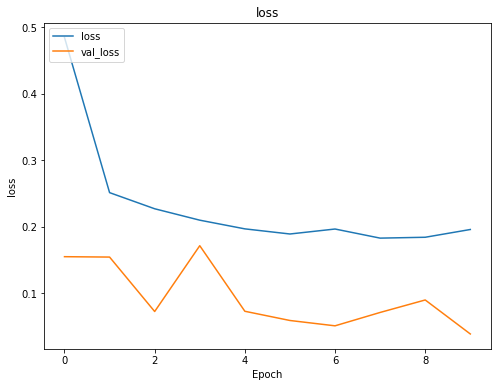

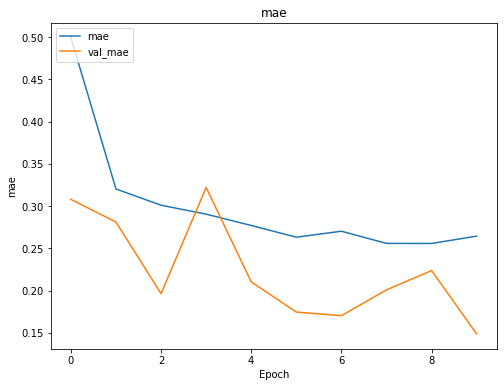

In [23]:
apt.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

In [24]:
best_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

8 92 299 1226
1/1 [==============================] - 0s 70ms/step
[[80.55908    1.0887612]]


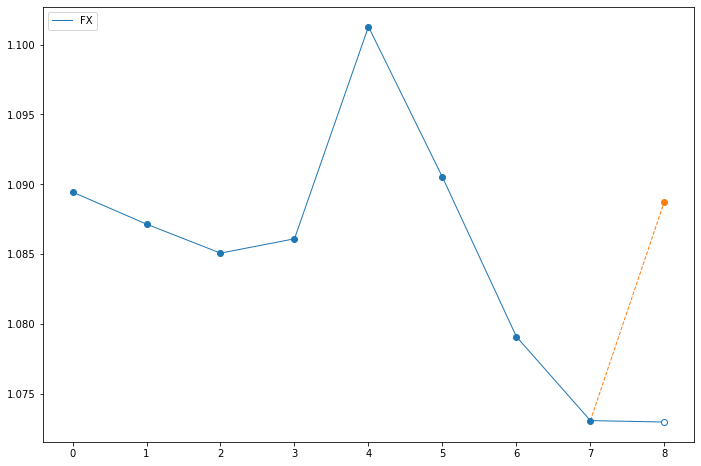

Gap between prediction and reality : 0.02 u


In [26]:
import math,random
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
j = len(dataset_test)-sequence_len
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]
print(sequence_len,i,j,len(dataset_train))

# ---- Prediction

pred = best_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

print(pred)
# ---- Show it
feat=1

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

delta=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta:.2f} u')

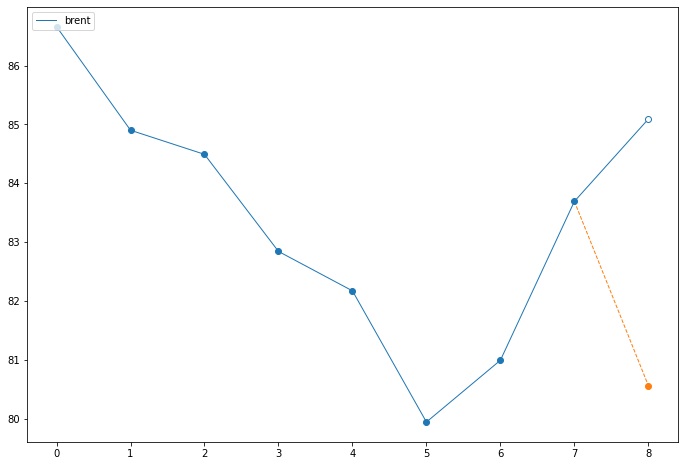

Gap between prediction and reality : 4.53 u


In [27]:
feat=0

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

delta=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta:.2f} u')

In [28]:
def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

2023-12-03 10:39:08.317364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 304ms/step


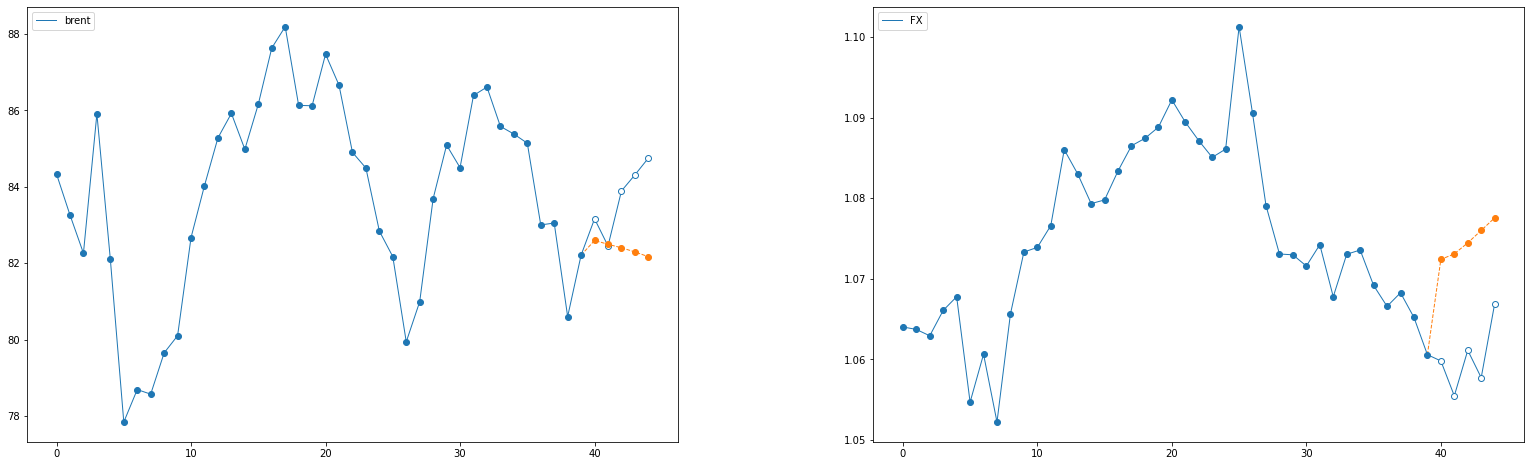

In [29]:
sequence_true, pred = get_prediction(dataset_test, best_model,iterations=5,sequence_len=40)

feat=[0,1]

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features,
                            only_features=feat,width=14, height=8)